In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import differential_evolution, newton
from scipy.integrate import odeint, solve_ivp
from scipy.special import kn
from astropy import constants as ct
import pandas as pd
from ipywidgets import interact,fixed,widgets,interactive
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [2]:
# Confidence level etc
alpha = 0.05
beta = 1. - alpha
critical_chi_sq = chi2.isf(alpha, 2)
critical_loglike = 0.5 * critical_chi_sq
min_chi_sq = 0.

In [3]:
# Scan settings
n_random_samples = int(1e7)
dim = 4
min_ = -5.
max_ = 5.
seed = 127


Likelihood function $\propto\mathcal{N}(\Omega_{obs},\Sigma)$. Thus, 

$$
\chi^2=\left(\dfrac{\Omega-\Omega_{obs}}{\Sigma}\right)^2
$$

with $\Omega_{obs}=0.12$ and $\Sigma=\sqrt{(0.1\Omega)^2+(0.001)^2}$

In [4]:
Omega_0 = 0.12
Sigma_th_rel = 0.1
Sigma_0 = 0.001

In [5]:
def chi_square(Omega):
    """
    Returns chi² function
    """
    Sigma = ((Sigma_th_rel*Omega)**2+(Sigma_0)**2)**0.5
    return ((Omega-Omega_0)/Sigma)**2

def loglike(Omega):
    """
    Returns log(L)
    """
    return -0.5*chi_square(Omega)

def samples_inside(x, chi_sq):
    """
    @returns Points from within delta chi-squared contour
    """
    delta_chi_sq = chi_sq - min_chi_sq
    inside = delta_chi_sq <= critical_chi_sq
    return x[:, inside]

$$
Y_0=\dfrac{3M_P^2\Omega_{DM}h^2(2.13\times10^{-42}\text{ GeV})^2}{ms_0}
$$


$$\Omega_{DM}h^2=\dfrac{Y_0ms_0}{3M_P^2(2.13\times 10^{-42}\text{ GeV})^2}$$

In [6]:
g = 2
gstar = 106.75
MP = 2.4e18 #GeV
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
abundance = 0.12
gstars0 = 3.91
gstar0 = 3.38

In [7]:
def Yeq(x,mass,g):
    neq = g/(2*np.pi**2)*mass**3/x*kn(2,x)
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    return neq/s

def WIMPs(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Yeq(x,mass,g)**2)
    return dYdx



In [14]:
def Omega(m,sigma,g=2):
    m = 10.**m
    sigma = 10.**sigma
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini, m, g)
    sol = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(m,sigma,g))
    Y0 = sol.y[0][-1]
    s0 = 2*np.pi**2/45*gstars0*T0**3
    Omegah2 = Y0*m*s0/(3*MP**2*(2.13e-42)**2)
    if Omegah2 > 0:
        return Omegah2
    else:
        return 0

Omega = np.vectorize(Omega)

In [16]:
def graf1(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.ylim(2e-8,1e-2)
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-15, max=-7,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot1 = interactive(graf1, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot1

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-3.0, step=0.0001), FloatLo…

In [17]:
def WIMPs_SA(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Y*Yeq(x,mass,g))
    return dYdx

def SIMPs(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s**2/(x*H)*(Y**3 - Y**2*Yeq(x,mass,g))
    return dYdx

In [21]:
def graf2(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-4, max=2,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-10, max=-3,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot2 = interactive(graf2, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot2

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=2.0, min=-4.0, step=0.0001), FloatLo…

In [22]:
def graf3(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-4, max=2,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-10, max=-3,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot3 = interactive(graf3, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot3

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=2.0, min=-4.0, step=0.0001), FloatLo…

In [11]:
def loglike_pars(P):
    m,sigma = P
    return loglike(Omega(m,sigma))
def chi_square_pars(P):
    m,sigma = P
    return chi_square(Omega(m,sigma))

In [13]:
bound_m = (-3,3)
bound_sigma = (-15,-7)

In [14]:
def de_scan(round_to_nearest=None):
    """
    @returns Points from within delta chi-squared contour from differential evolution
    and number of calls
    """
    bounds = [bound_m,bound_sigma]
    x = []
    chi_sq = []

    def objective(x_):
        """
        @returns Objective for DE that saves chi-squared and parameters
        """
        chi_sq_ = chi_square_pars(x_)
        chi_sq.append(chi_sq_)
        x.append(x_)
        return chi_sq_

    differential_evolution(objective, bounds,
                           strategy='rand1bin', maxiter=None,
                           popsize=50, tol=0.01, mutation=(0.7, 1.99999), recombination=0.15,
                           polish=False,seed=seed)

    if round_to_nearest is not None:
        len_x = len(x)
        keep_n = len_x - (len_x % round_to_nearest)
        x = x[:keep_n]
        chi_sq = chi_sq[:keep_n]

    return samples_inside(np.array(x).T, np.array(chi_sq)), len(x)

In [15]:
chi_square_pars((2,np.log10(1.26e-9)))

1.96517625134483

In [16]:
ms = np.linspace(*bound_m)
sigmas = np.linspace(*bound_sigma)

Ms, Sigmas = np.meshgrid(ms,sigmas)
Os = Omega(Ms,Sigmas)

In [49]:
np.random.seed(seed)

print('Running de_scan')
t0 = time.time()
x,calls = de_scan(round_to_nearest=1000)
de_time = time.time() - t0
print('Time = ', de_time)

Running de_scan
Time =  8975.11249923706


<Figure size 640x480 with 0 Axes>

In [64]:
omegas_chi2 = Omega(x[0],x[1])

In [119]:
def Omegah2_analytic(mass,sigma,n=0):
    A = np.log(0.038*(n+1)*g/(gstar**0.5)*(8*np.pi)**0.5*MP*mass*sigma)
    xf = A-(n+0.5)*np.log(A)
    omh = 1.07e9*(n+1)*xf**(n+1)/((gstar/gstar**0.5)*(8*np.pi)**0.5*MP*sigma)
    return omh

Omegah2_analytic = np.vectorize(Omegah2_analytic)

In [138]:
om_an = Omegah2_analytic(10.**x[0],10.**x[1])
Os_an = Omegah2_analytic(10.**Ms,10.**Sigmas)

/tmp/ipykernel_14614/493708718.py:3: RuntimeWarning: invalid value encountered in log
  xf = A-(n+0.5)*np.log(A)


In [128]:
df = pd.DataFrame()
df['log(m)'] = pd.Series(x[0])
df['log(sigma*v)'] = pd.Series(x[1])
df['Omegah2'] = pd.Series(omegas_chi2)
df['Omegah2_a'] = pd.Series(om_an)
df['Delta'] = (df['Omegah2_a'] - df['Omegah2'])/df['Omegah2_a']*100

df.to_csv('optimal_params.csv',index=False)
df

,log(m),log(sigma*v),Omegah2,Omegah2_a,Delta
0,1.438485,-8.757758,0.103633,0.101601,-1.999844
1,-0.724954,-8.934397,0.115655,0.113749,-1.676004
2,2.657775,-8.709958,0.097813,0.103617,5.601821
3,-1.457144,-9.057603,0.133283,0.132317,-0.729898
4,-0.894794,-8.934397,0.110638,0.110942,0.273684
...,...,...,...,...,...
59943,-2.726706,-9.101897,0.115909,0.114842,-0.928885
59944,-2.815848,-9.100436,0.113492,0.112360,-1.007217
59945,-1.920078,-9.127031,0.142798,0.141616,-0.834237
59946,-1.835097,-9.031917,0.118646,0.117465,-1.005568


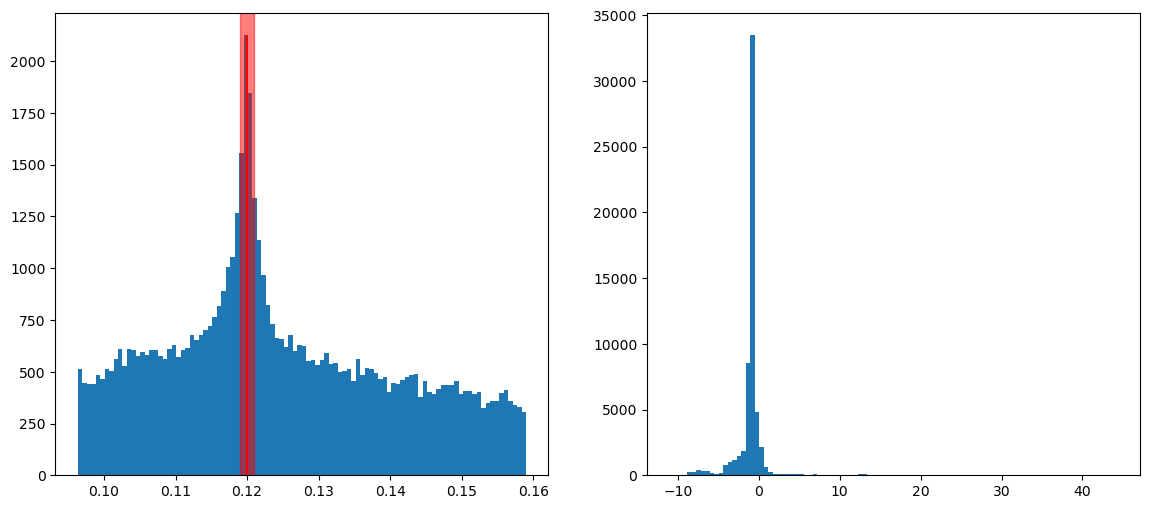

In [129]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

hist = ax[0].hist(df['Omegah2'],bins=100)
ax[0].vlines(0.12,0,hist[0].max(),color='r')
ax[0].axvspan(0.119,0.121,0,hist[0].max(),color='r',alpha=0.5)

hist2 = ax[1].hist(df['Delta'],bins=100)

Plotting de_scan


/tmp/ipykernel_14614/311854025.py:3: RuntimeWarning: divide by zero encountered in log10
  CS = ax.contourf(Ms,Sigmas,np.log10(Os),cmap='inferno',)


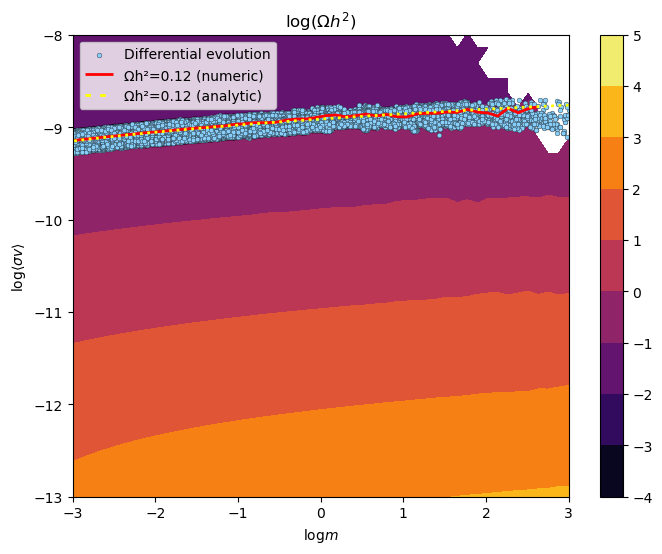

In [185]:
print('Plotting de_scan')
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Os),cmap='inferno',)
de_scatter = ax.scatter(x[0], x[1], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms,Sigmas,np.log10(Os_an),levels=[np.log10(0.12),],colors='yellow',linestyles='dotted',linewidths=2)
cbar = fig.colorbar(CS)

ax.legend()

h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$')
ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2.pdf')
plt.show()